# Capstone Project Week 4-5

## Introduction

In this project, I will focus on analysis the distribution of business location in LA vs NY. Both cities are popular cities in the US. But one locate on west coast and one on east coast. In addition, although both cities are huge, the lifestyle are different for the people in these two cities. So I want to analysis how businesses locate in both cities and what type of business are popular in these two cities. Especially in downtown area.

## Data
For this project, I'm going to collect all businesses data from foursquare for both cities. Then clustering them in to different groups and generate a map with locations of those business. So I know where are the business locate at and what type of business take the most effort in the city. 

In [16]:
import requests
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import geopy
from bs4 import BeautifulSoup
import geocoder
from geopy.geocoders import Nominatim
import json
import urllib.request
from sklearn.cluster import KMeans

In [17]:
#get all districts and neighborhoods of LA and clean the data.
url = 'https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
Neighborhood = {'Neighborhood' : []}
for link in soup.find_all('a'):
    if link.get('title') != None:
        Neighborhood['Neighborhood'].append(link.get('title'))
la_neigh = pd.DataFrame(Neighborhood)
la_neigh = la_neigh[la_neigh['Neighborhood'].str.contains(', Los Angeles')].reset_index()
la_neigh = la_neigh[0:185]
la_neigh['Neighborhood'] = la_neigh['Neighborhood'].str.split(',').str.get(0)
la_neigh = la_neigh.replace(['Mandeville Canyon','Rustic Canyon','Westwood Village','Wilshaire Center','Westdale','Benedict Canyon','Beachwood Canyon','Hermon','Elysian Heights','Solano Canyon',
                   'Sunland-Tujunga',
'Elysian Heights',
'Angelino Heights',
'Village Green',
'Crenshaw',
'Florence',
'Skid Row',
'Financial District',
'Civic Center',
'Fashion District'],
                    ['Brentwood','Pacific Palisades','Westwood',
'Westwood',
'Rancho Park',
'Beverly Hills',
'Hollywood Hills',
'Highland Park',
'Elysian Valley',
'Elysian Park',
'Tujunga',
'Elysan Valley',
'Echo Park',
'Baldwin Hills/Crenshaw',
'Hawthorne',
'Florence-Firestone',
'Downtown',
'Downtown',
'Downtown',
'Downtown'
])

In [23]:
# generate 144 available district in LA
geolocator = Nominatim(user_agent = 'LA_finder')
la_coords = pd.DataFrame({'Neighborhood':[],'Latitude':[],'Longitude':[]})
for row in la_neigh.index:
    neighborhood = la_neigh['Neighborhood'][row]
    address = '{}, Los Angeles, CA'.format(neighborhood)
    location = geolocator.geocode(address)
    if location != None:
        la_coords = la_coords.append({'Neighborhood': la_neigh['Neighborhood'][row],
                                     'Latitude': location.latitude,
                                     'Longitude': location.longitude}, ignore_index = True)


In [24]:
#86 neighborhood with zip code
#index_del = la_coords[la_coords['Zip']==' California'].index
#la_coords.drop(index_del, inplace = True)
#la_coords = la_coords.reset_index()
la_coords

Neighborhood   Latitude   Longitude
0            Echo Park  34.077982 -118.256782
1         Angeles Mesa  33.991402 -118.319520
2               Arleta  34.241327 -118.432205
3    Arlington Heights  34.043494 -118.321374
4        Arts District  34.041239 -118.234450
..                 ...        ...         ...
139         Wilmington  33.780016 -118.262509
140    Wilshire Center  34.061515 -118.432771
141     Windsor Square  34.068973 -118.319988
142           Winnetka  34.197449 -118.571006
143     Woodland Hills  34.168436 -118.605838

[144 rows x 3 columns]

In [25]:
#for row in la_coords.index:
    #if '-' in la_coords['Zip'][row]:
        #la_coords['Zip'][row] = la_coords['Zip'][row].strip().split('-')[0]
#la_coords


Neighborhood   Latitude   Longitude
0            Echo Park  34.077982 -118.256782
1         Angeles Mesa  33.991402 -118.319520
2               Arleta  34.241327 -118.432205
3    Arlington Heights  34.043494 -118.321374
4        Arts District  34.041239 -118.234450
..                 ...        ...         ...
139         Wilmington  33.780016 -118.262509
140    Wilshire Center  34.061515 -118.432771
141     Windsor Square  34.068973 -118.319988
142           Winnetka  34.197449 -118.571006
143     Woodland Hills  34.168436 -118.605838

[144 rows x 3 columns]

In [27]:
# Display districts on map
la_location = geolocator.geocode('Los Angeles, CA')
map_la = folium.Map([la_location.latitude,la_location.longitude],zoom_start=10)

for lat,lng,neigh in zip(la_coords['Latitude'],la_coords['Longitude'],la_coords['Neighborhood']):
    label = '{}'.format(neigh)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup=label,
        color='blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html=False).add_to(map_la)
    
map_la

In [28]:
# Start with Foursquare API
CLIENT_ID = 'WBWCB0Y5FNG13MNUIZLERYJI1WLBPTGVPIZZCYVIZHRVPLDL'
CLIENT_SECRET= 'UMUGWMFE2DYYIJUYGEQYT23WIY04HGOAJ5IORUDXY4INE3B3'
VERSION = '20201001'
LIMIT = 100

In [29]:
limit = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [67]:
la_venues = getNearbyVenues(names=la_coords['Neighborhood'], latitudes=la_coords['Latitude'],longitudes=la_coords['Longitude'])

Echo Park
Angeles Mesa
Arleta
Arlington Heights
Arts District
Atwater Village
Baldwin Hills/Crenshaw
Hollywood Hills
Bel Air
Beverly Hills
Beverly Crest
Beverly Glen
Beverly Grove
Beverly Park
Beverlywood
Boyle Heights
Brentwood
Broadway-Manchester
Brookside
Bunker Hill
Canoga Park
Harvard Park
Carthay
Central-Alameda
Century City
Chatsworth
Chesterfield Square
Cheviot Hills
Chinatown
Downtown
Hawthorne
Cypress Park
Del Rey
Eagle Rock
East Hollywood
Echo Park
Edendale
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Downtown
Downtown
Florence-Firestone
Gallery Row
Garvanza
Glassell Park
Gramercy Park
Granada Hills
Green Meadows
Hancock Park
Harbor City
Harbor Gateway
Harvard Heights
Harvard Park
Highland Park
Highland Park
Historic Core
Hollywood Hills West
Hyde Park
Jefferson Park
Koreatown
Ladera
Lake Balboa
Lake View Terrace
Larchmont
Laurel Canyon
Leimert Park
Lincoln Heights
Little Armenia
Chinatown
Little Tokyo
Los Feliz
Manchester Square
Brentwood
Mar Vista
Mid-City


In [68]:
la_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0          Echo Park              34.077982             -118.256782   
1          Echo Park              34.077982             -118.256782   
2          Echo Park              34.077982             -118.256782   
3          Echo Park              34.077982             -118.256782   
4          Echo Park              34.077982             -118.256782   
...              ...                    ...                     ...   
3337  Woodland Hills              34.168436             -118.605838   
3338  Woodland Hills              34.168436             -118.605838   
3339  Woodland Hills              34.168436             -118.605838   
3340  Woodland Hills              34.168436             -118.605838   
3341  Woodland Hills              34.168436             -118.605838   

                          Venue  Venue Latitude  Venue Longitude  \
0                  Ostrich Farm       34.076272      -118.255919   
1     Sage Organic Vegan Bistro       34.077150      -118.258510   
2          Stories Books & Cafe       34.077240      -118.259186   
3     Blue Corn Quesadilla Lady       34.076270      -118.257822   
4                       Hey Hey       34.076622      -118.256676   
...                         ...             ...              ...   
3337      Dickey's Barbecue Pit       34.168559      -118.603435   
3338                Yogurt Zone       34.169443      -118.604502   
3339     Lotus Inn China Bistro       34.168605      -118.602055   
3340                    Anantra       34.169638      -118.602212   
3341                    Trimana       34.171741      -118.602558   

                     Venue Category  
0               American Restaurant  
1     Vegetarian / Vegan Restaurant  
2                         Bookstore  
3         Latin American Restaurant  
4                       Coffee Shop  
...                             ...  
3337                      BBQ Joint  
3338                 Ice Cream Shop  
3339             Chinese Restaurant  
3340                Thai Restaurant  
3341                           Café  

[3342 rows x 7 columns]

In [69]:
la_venues.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

In [70]:
la_category = la_venues.groupby('Venue Category').count().reset_index()
la_category = la_category.sort_values('Venue',ascending = False)
la_category

Venue Category  Neighborhood  Neighborhood Latitude  \
60          Coffee Shop           140                    140   
179  Mexican Restaurant           112                    112   
233      Sandwich Place            80                     80   
25                  Bar            74                     74   
213         Pizza Place            72                     72   
..                  ...           ...                    ...   
132      Gymnastics Gym             1                      1   
129           Gun Range             1                      1   
125         Golf Course             1                      1   
124       Go Kart Track             1                      1   
299  Yoshoku Restaurant             1                      1   

     Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  
60                      140    140             140              140  
179                     112    112             112              112  
233                      80     80              80               80  
25                       74     74              74               74  
213                      72     72              72               72  
..                      ...    ...             ...              ...  
132                       1      1               1                1  
129                       1      1               1                1  
125                       1      1               1                1  
124                       1      1               1                1  
299                       1      1               1                1  

[300 rows x 7 columns]

[Text(0, 0.5, 'Business type'), Text(0.5, 0, 'Number of business type')]

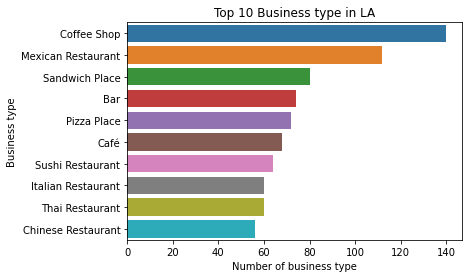

In [109]:
fig = sns.barplot(la_category['Venue'].head(10),la_category['Venue Category'].head(10))
fig.set_title('Top 10 Business type in LA')
fig.set(xlabel='Number of business type', ylabel='Business type')

In [72]:
la_venues.groupby('Neighborhood').count()
la_v = la_venues.groupby('Neighborhood').count()
la_v = la_v.reset_index()
#la_v.iloc[1,0] = '90014'
#la_v['Zip'].str.strip()
la_v

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  Venue  \
0         Angeles Mesa                      6                       6      6   
1               Arleta                      4                       4      4   
2    Arlington Heights                     11                      11     11   
3        Arts District                     30                      30     30   
4      Atwater Village                     43                      43     43   
..                 ...                    ...                     ...    ...   
122         Wilmington                     15                      15     15   
123    Wilshire Center                     11                      11     11   
124     Windsor Square                      4                       4      4   
125           Winnetka                     12                      12     12   
126     Woodland Hills                     54                      54     54   

     Venue Latitude  Venue Longitude  Venue Category  
0                 6                6               6  
1                 4                4               4  
2                11               11              11  
3                30               30              30  
4                43               43              43  
..              ...              ...             ...  
122              15               15              15  
123              11               11              11  
124               4                4               4  
125              12               12              12  
126              54               54              54  

[127 rows x 7 columns]

In [73]:
la_v = la_v.sort_values('Venue Category', ascending = False)

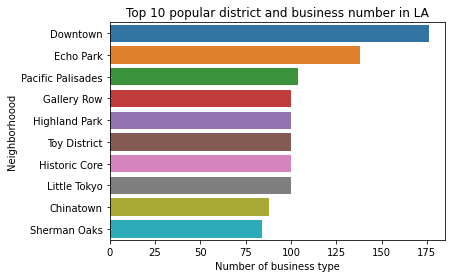

In [108]:
fig = sns.barplot(la_v['Venue Category'].head(10),la_v['Neighborhood'].head(10))
fig.set_title('Top 10 popular district and business number in LA')
fig.set(xlabel='Number of business type', ylabel='Neighborhoood')
plt.savefig('Top 10 versatile district LA',bbox_inches='tight')

In [75]:
map_la2 = folium.Map([la_location.latitude,la_location.longitude],zoom_start=10)
la_geo = 'http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v6.geojson'
folium.Choropleth(
    geo_data = la_geo,
    data=la_v,
    columns=['Neighborhood', 'Venue Category'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name = "Diversity of Business type",
    bins = [0,25,50,75,125,180]
    ).add_to(map_la2)

for lat,lng,neigh in zip(la_coords['Latitude'],la_coords['Longitude'],la_coords['Neighborhood']):
        label = '{}'.format(neigh)
        label = folium.Popup(label, parse_html = True)
        folium.CircleMarker(
            [lat,lng],
            radius = 2,
            popup=label,
            color='blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.4,
            parse_html=False).add_to(map_la2)
        
folium.LayerControl().add_to(map_la2)

map_la2

In [76]:
#clustering
len(la_venues['Venue Category'].unique())

300

In [77]:
la_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                              
Angeles Mesa                           6                       6      6   
Arleta                                 4                       4      4   
Arlington Heights                     11                      11     11   
Arts District                         30                      30     30   
Atwater Village                       43                      43     43   
...                                  ...                     ...    ...   
Wilmington                            15                      15     15   
Wilshire Center                       11                      11     11   
Windsor Square                         4                       4      4   
Winnetka                              12                      12     12   
Woodland Hills                        54                      54     54   

                   Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                        
Angeles Mesa                    6                6               6  
Arleta                          4                4               4  
Arlington Heights              11               11              11  
Arts District                  30               30              30  
Atwater Village                43               43              43  
...                           ...              ...             ...  
Wilmington                     15               15              15  
Wilshire Center                11               11              11  
Windsor Square                  4                4               4  
Winnetka                       12               12              12  
Woodland Hills                 54               54              54  

[127 rows x 6 columns]

In [78]:
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix = '',prefix_sep='')
la_onehot['Neighborhood'] = la_venues['Neighborhood']

fixed_columns = [la_onehot.columns[-1]]+list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.shape

(3342, 300)

In [79]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped

Neighborhood  Yoshoku Restaurant  ATM  Accessories Store  \
0         Angeles Mesa                 0.0  0.0                0.0   
1               Arleta                 0.0  0.0                0.0   
2    Arlington Heights                 0.0  0.0                0.0   
3        Arts District                 0.0  0.0                0.0   
4      Atwater Village                 0.0  0.0                0.0   
..                 ...                 ...  ...                ...   
122         Wilmington                 0.0  0.0                0.0   
123    Wilshire Center                 0.0  0.0                0.0   
124     Windsor Square                 0.0  0.0                0.0   
125           Winnetka                 0.0  0.0                0.0   
126     Woodland Hills                 0.0  0.0                0.0   

     Adult Boutique  American Restaurant  Amphitheater  Andhra Restaurant  \
0               0.0             0.000000           0.0                0.0   
1               0.0             0.000000           0.0                0.0   
2               0.0             0.000000           0.0                0.0   
3               0.0             0.000000           0.0                0.0   
4               0.0             0.023256           0.0                0.0   
..              ...                  ...           ...                ...   
122             0.0             0.000000           0.0                0.0   
123             0.0             0.000000           0.0                0.0   
124             0.0             0.000000           0.0                0.0   
125             0.0             0.000000           0.0                0.0   
126             0.0             0.000000           0.0                0.0   

     Antique Shop  Aquarium  ...  Video Store  Vietnamese Restaurant  \
0             0.0       0.0  ...     0.000000               0.000000   
1             0.0       0.0  ...     0.000000               0.000000   
2             0.0       0.0  ...     0.000000               0.000000   
3             0.0       0.0  ...     0.000000               0.000000   
4             0.0       0.0  ...     0.000000               0.046512   
..            ...       ...  ...          ...                    ...   
122           0.0       0.0  ...     0.066667               0.000000   
123           0.0       0.0  ...     0.000000               0.000000   
124           0.0       0.0  ...     0.000000               0.000000   
125           0.0       0.0  ...     0.000000               0.000000   
126           0.0       0.0  ...     0.018519               0.000000   

     Warehouse Store  Waterfront  Whisky Bar  Wine Bar  Wine Shop  \
0                0.0         0.0         0.0  0.166667        0.0   
1                0.0         0.0         0.0  0.000000        0.0   
2                0.0         0.0         0.0  0.000000        0.0   
3                0.0         0.0         0.0  0.000000        0.0   
4                0.0         0.0         0.0  0.023256        0.0   
..               ...         ...         ...       ...        ...   
122              0.0         0.0         0.0  0.000000        0.0   
123              0.0         0.0         0.0  0.000000        0.0   
124              0.0         0.0         0.0  0.000000        0.0   
125              0.0         0.0         0.0  0.000000        0.0   
126              0.0         0.0         0.0  0.000000        0.0   

     Wings Joint  Women's Store  Yoga Studio  
0            0.0            0.0          0.0  
1            0.0            0.0          0.0  
2            0.0            0.0          0.0  
3            0.0            0.0          0.0  
4            0.0            0.0          0.0  
..           ...            ...          ...  
122          0.0            0.0          0.0  
123          0.0            0.0          0.0  
124          0.0            0.0          0.0  
125          0.0            0.0          0.0  
126          0.0            0.0  

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood      1st Most Common Venue 2nd Most Common Venue  \
0       Angeles Mesa              Deli / Bodega              Wine Bar   
1             Arleta              Movie Theater          Home Service   
2  Arlington Heights  Latin American Restaurant                  Café   
3      Arts District                Coffee Shop           Art Gallery   
4    Atwater Village                Coffee Shop           Pizza Place   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0             Restaurant            Playground             Pet Store  
1          Historic Site   Filipino Restaurant    English Restaurant  
2           Liquor Store                  Food     Convenience Store  
3     Italian Restaurant                  Café          Cocktail Bar  
4  Vietnamese Restaurant          Liquor Store              Boutique

In [82]:
# set number of clusters
kclusters = 5

la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 3, 0, 2, 0, 0])

In [83]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_coords = la_coords.rename({'Neighbourhood':'Neighborhood'},axis = 1)

la_merged = la_coords

la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

la_merged.head() # check the last columns!

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Echo Park  34.077982 -118.256782               0   
1       Angeles Mesa  33.991402 -118.319520               0   
2             Arleta  34.241327 -118.432205               0   
3  Arlington Heights  34.043494 -118.321374               0   
4      Arts District  34.041239 -118.234450               0   

       1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                Coffee Shop                   Bar    Mexican Restaurant   
1              Deli / Bodega              Wine Bar            Restaurant   
2              Movie Theater          Home Service         Historic Site   
3  Latin American Restaurant                  Café          Liquor Store   
4                Coffee Shop           Art Gallery    Italian Restaurant   

  4th Most Common Venue 5th Most Common Venue  
0                  Café            Food Truck  
1            Playground             Pet Store  
2   Filipino Restaurant    English Restaurant  
3                  Food     Convenience Store  
4                  Café          Cocktail Bar

In [84]:
# create map
map_clusters = folium.Map([la_location.latitude,la_location.longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'],la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [129]:
la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

Neighborhood      1st Most Common Venue 2nd Most Common Venue  \
0            Echo Park                Coffee Shop                   Bar   
1         Angeles Mesa              Deli / Bodega              Wine Bar   
2               Arleta              Movie Theater          Home Service   
3    Arlington Heights  Latin American Restaurant                  Café   
4        Arts District                Coffee Shop           Art Gallery   
..                 ...                        ...                   ...   
139         Wilmington               Burger Joint     Mobile Phone Shop   
140    Wilshire Center                      Hotel  Gym / Fitness Center   
141     Windsor Square        Sporting Goods Shop  Gym / Fitness Center   
142           Winnetka                      Diner            Restaurant   
143     Woodland Hills           Sushi Restaurant        Ice Cream Shop   

        3rd Most Common Venue 4th Most Common Venue  \
0          Mexican Restaurant                  Café   
1                  Restaurant            Playground   
2               Historic Site   Filipino Restaurant   
3                Liquor Store                  Food   
4          Italian Restaurant                  Café   
..                        ...                   ...   
139               Video Store    Seafood Restaurant   
140              Intersection                  Pool   
141                   Dog Run        Scenic Lookout   
142               Gas Station            Donut Shop   
143  Mediterranean Restaurant              Pharmacy   

                        5th Most Common Venue  
0                                  Food Truck  
1                                   Pet Store  
2                          English Restaurant  
3                           Convenience Store  
4                                Cocktail Bar  
..                                        ...  
139                        Chinese Restaurant  
140  Residential Building (Apartment / Condo)  
141                               Yoga Studio  
142                               Coffee Shop  
143                                       Spa  

[132 rows x 6 columns]

In [130]:
la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
14         Beverlywood                  Park         Burrito Place   
21        Harvard Park                  Park           Yoga Studio   
55        Harvard Park                  Park           Yoga Studio   
80   Montecito Heights                  Park                  Food   
105         South Park                  Park         Grocery Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
14            Yoga Studio   Filipino Restaurant           Escape Room  
21   Fast Food Restaurant    English Restaurant           Escape Room  
55   Fast Food Restaurant    English Restaurant           Escape Room  
80            Yoga Studio  Fast Food Restaurant    English Restaurant  
105           Video Store        Farmers Market     Electronics Store

In [131]:
la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
10  Beverly Crest     Convenience Store           Yoga Studio   
48  Gramercy Park     Convenience Store        Discount Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
10   Filipino Restaurant    English Restaurant           Escape Room  
48                  Pool           Flea Market           Escape Room

In [132]:
la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
6    Baldwin Hills/Crenshaw                 Trail                  Park   
7           Hollywood Hills                 Trail   Filipino Restaurant   
65        Lake View Terrace                 Trail                Garden   
128  Baldwin Hills/Crenshaw                 Trail                  Park   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
6    Fast Food Restaurant    English Restaurant           Escape Room  
7      English Restaurant           Escape Room  Ethiopian Restaurant  
65    Filipino Restaurant    English Restaurant           Escape Room  
128  Fast Food Restaurant    English Restaurant           Escape Room

In [133]:
la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[0] + list(range(4, la_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
93  Porter Ranch                   Gym           Yoga Studio   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
93  Fast Food Restaurant    English Restaurant           Escape Room

In [13]:
#get NYC data
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
filename = 'ny_data.json'
urllib.request.urlretrieve(url,filename)

#nyc_data = pd.DataFrame(nyc_json['ntaname'])

('ny_data.json', <http.client.HTTPMessage at 0x276d85e1d00>)

In [14]:
with open('ny_data.json') as json_data:
    newyork_data = json.load(json_data)

In [15]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [34]:
neighborhoods_data = newyork_data['features']

In [36]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [37]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [38]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [39]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [40]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [41]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [42]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

In [43]:
manhattan_venues = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'],longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [44]:
print(manhattan_venues.shape)
manhattan_venues.head()

(10107, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3         Walgreens       40.896528       -73.844700        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

In [96]:
ny_category = manhattan_venues.groupby('Venue Category').count().reset_index()
ny_category

Venue Category  Neighborhood  Neighborhood Latitude  \
0     Accessories Store             8                      8   
1        Adult Boutique             1                      1   
2     Afghan Restaurant             2                      2   
3    African Restaurant             6                      6   
4      Airport Terminal             1                      1   
..                  ...           ...                    ...   
423            Wine Bar            68                     68   
424           Wine Shop            88                     88   
425         Wings Joint            12                     12   
426       Women's Store            23                     23   
427         Yoga Studio            80                     80   

     Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  
0                         8      8               8                8  
1                         1      1               1                1  
2                         2      2               2                2  
3                         6      6               6                6  
4                         1      1               1                1  
..                      ...    ...             ...              ...  
423                      68     68              68               68  
424                      88     88              88               88  
425                      12     12              12               12  
426                      23     23              23               23  
427                      80     80              80               80  

[428 rows x 7 columns]

In [103]:
ny_category_top10 = ny_category.sort_values('Venue', ascending = False).head(10)
ny_category_top10

Venue Category  Neighborhood  Neighborhood Latitude  \
300         Pizza Place           438                    438   
208  Italian Restaurant           319                    319   
83          Coffee Shop           311                    311   
109       Deli / Bodega           271                    271   
24               Bakery           228                    228   
26                  Bar           225                    225   
75   Chinese Restaurant           223                    223   
171       Grocery Store           196                    196   
334      Sandwich Place           186                    186   
285                Park           181                    181   

     Neighborhood Longitude  Venue  Venue Latitude  Venue Longitude  
300                     438    438             438              438  
208                     319    319             319              319  
83                      311    311             311              311  
109                     271    271             271              271  
24                      228    228             228              228  
26                      225    225             225              225  
75                      223    223             223              223  
171                     196    196             196              196  
334                     186    186             186              186  
285                     181    181             181              181

[Text(0, 0.5, 'Business type'), Text(0.5, 0, 'Number of business type')]

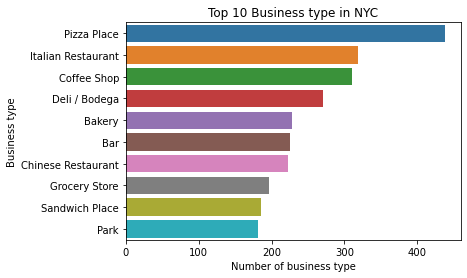

In [123]:
fig = sns.barplot(ny_category_top10['Venue'],ny_category_top10['Venue Category'])
fig.set_title('Top 10 Business type in NYC')
fig.set(xlabel='Number of business type', ylabel='Business type')

In [116]:
ny_v = manhattan_venues.groupby('Neighborhood').count().reset_index()
ny_v = ny_v.sort_values('Venue Category',ascending = False)
ny_v = ny_v.reset_index()
#la_v.iloc[1,0] = '90014'
#la_v['Zip'].str.strip()
ny_v_top10 = ny_v.head(10)
ny_v_top10

index        Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    186         Murray Hill                    146                     146   
1     49             Chelsea                    106                     106   
2    151          Lenox Hill                    100                     100   
3    155        Little Italy                    100                     100   
4     50           Chinatown                    100                     100   
5     53        Civic Center                    100                     100   
6     57             Clinton                    100                     100   
7     73            Downtown                    100                     100   
8     81        East Village                    100                     100   
9     95  Financial District                    100                     100   

   Venue  Venue Latitude  Venue Longitude  Venue Category  
0    146             146              146             146  
1    106             106              106             106  
2    100             100              100             100  
3    100             100              100             100  
4    100             100              100             100  
5    100             100              100             100  
6    100             100              100             100  
7    100             100              100             100  
8    100             100              100             100  
9    100             100              100             100

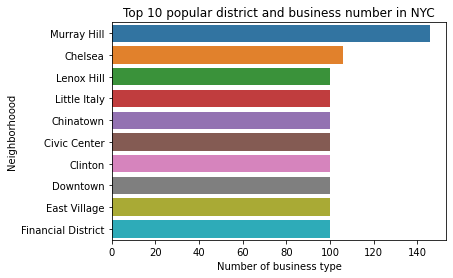

In [117]:
fig = sns.barplot(x=ny_v_top10['Venue Category'],y=ny_v_top10['Neighborhood'])
fig.set_title('Top 10 popular district and business number in NYC')
fig.set(xlabel='Number of business type', ylabel='Neighborhoood')
plt.savefig('Top 10 versatile district NYC',bbox_inches='tight')

In [122]:
map_ny = folium.Map([location.latitude,location.longitude],zoom_start=10)
ny_geo = 'https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson'
folium.Choropleth(
    geo_data = ny_geo,
    data=ny_v,
    columns=['Neighborhood', 'Venue Category'],
    key_on='feature.properties.neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.3,
    legend_name = "Diversity of Business type",
    ).add_to(map_ny)

for lat,lng,neigh in zip(neighborhoods['Latitude'],neighborhoods['Longitude'],neighborhoods['Neighborhood']):
        label = '{}'.format(neigh)
        label = folium.Popup(label, parse_html = True)
        folium.CircleMarker(
            [lat,lng],
            radius = 2,
            popup=label,
            color='blue',
            fill = True,
            fill_color = '#3186cc',
            fill_opacity = 0.4,
            parse_html=False).add_to(map_ny)
        
folium.LayerControl().add_to(map_ny)

map_ny

In [45]:
manhattan_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                          
Allerton                          30                      30     30   
Annadale                          11                      11     11   
Arden Heights                      5                       5      5   
Arlington                          6                       6      6   
Arrochar                          22                      22     22   
...                              ...                     ...    ...   
Woodhaven                         25                      25     25   
Woodlawn                          25                      25     25   
Woodrow                           21                      21     21   
Woodside                          75                      75     75   
Yorkville                        100                     100    100   

               Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                    
Allerton                   30               30              30  
Annadale                   11               11              11  
Arden Heights               5                5               5  
Arlington                   6                6               6  
Arrochar                   22               22              22  
...                       ...              ...             ...  
Woodhaven                  25               25              25  
Woodlawn                   25               25              25  
Woodrow                    21               21              21  
Woodside                   75               75              75  
Yorkville                 100              100             100  

[302 rows x 6 columns]

In [46]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 428 uniques categories.


In [47]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  ...  Volleyball Court  Warehouse Store  \
0       0                 0  ...                 0                0   
1       0                 0  ...                 0                0   
2       0                 0  ...                 0                0   
3       0                 0  ...                 0                0   
4       0                 0  ...                 0                0   

   Waste Facility  Waterfront  Weight Loss Center  Whisky Bar  Wine Bar  \
0               0           0                   0           0         0   
1               0           0                   0           0         0   
2               0           0                   0           0         0   
3               0           0                   0           0         0   
4               0           0                   0           0         0   

   Wine Shop  Wings Joint  Women's Store  
0          0            0              0  
1          0            0              0  
2          0            0              0  
3          0            0              0  
4          0            0              0  

[5 rows x 428 columns]

In [48]:
manhattan_onehot.shape

(10107, 428)

In [49]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

Neighborhood  Yoga Studio  Accessories Store  Adult Boutique  \
0         Allerton          0.0                0.0             0.0   
1         Annadale          0.0                0.0             0.0   
2    Arden Heights          0.0                0.0             0.0   
3        Arlington          0.0                0.0             0.0   
4         Arrochar          0.0                0.0             0.0   
..             ...          ...                ...             ...   
297      Woodhaven          0.0                0.0             0.0   
298       Woodlawn          0.0                0.0             0.0   
299        Woodrow          0.0                0.0             0.0   
300       Woodside          0.0                0.0             0.0   
301      Yorkville          0.0                0.0             0.0   

     Afghan Restaurant  African Restaurant  Airport Terminal  \
0                  0.0                 0.0               0.0   
1                  0.0                 0.0               0.0   
2                  0.0                 0.0               0.0   
3                  0.0                 0.0               0.0   
4                  0.0                 0.0               0.0   
..                 ...                 ...               ...   
297                0.0                 0.0               0.0   
298                0.0                 0.0               0.0   
299                0.0                 0.0               0.0   
300                0.0                 0.0               0.0   
301                0.0                 0.0               0.0   

     American Restaurant  Antique Shop  Arcade  ...  Volleyball Court  \
0               0.000000           0.0     0.0  ...               0.0   
1               0.181818           0.0     0.0  ...               0.0   
2               0.000000           0.0     0.0  ...               0.0   
3               0.000000           0.0     0.0  ...               0.0   
4               0.000000           0.0     0.0  ...               0.0   
..                   ...           ...     ...  ...               ...   
297             0.000000           0.0     0.0  ...               0.0   
298             0.000000           0.0     0.0  ...               0.0   
299             0.000000           0.0     0.0  ...               0.0   
300             0.040000           0.0     0.0  ...               0.0   
301             0.000000           0.0     0.0  ...               0.0   

     Warehouse Store  Waste Facility  Waterfront  Weight Loss Center  \
0                0.0             0.0         0.0                 0.0   
1                0.0             0.0         0.0                 0.0   
2                0.0             0.0         0.0                 0.0   
3                0.0             0.0         0.0                 0.0   
4                0.0             0.0         0.0                 0.0   
..               ...             ...         ...                 ...   
297              0.0             0.0         0.0                 0.0   
298              0.0             0.0         0.0                 0.0   
299              0.0             0.0         0.0                 0.0   
300              0.0             0.0         0.0                 0.0   
301              0.0             0.0         0.0                 0.0   

     Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  
0           0.0      0.00   0.000000          0.0            0.0  
1           0.0      0.00   0.000000          0.0            0.0  
2           0.0      0.00   0.000000          0.0            0.0  
3           0.0      0.00   0.000000          0.0            0.0  
4           0.0      0.00   0.000000          0.0            0.0  
..          ...       ...        ...          ...            ...  
297         0.0      0.00   0.000000          0.0            0.0  
298         0.0      0.00   0.000000          0.0            0.0  
299         0.0      0.00   0.000000          0.0  

In [50]:
manhattan_grouped.shape

(302, 428)

In [51]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0         Pizza Place  0.13
1       Deli / Bodega  0.07
2         Supermarket  0.07
3                 Spa  0.07
4  Chinese Restaurant  0.07


----Annadale----
                 venue  freq
0  American Restaurant  0.18
1          Pizza Place  0.18
2         Dance Studio  0.09
3        Train Station  0.09
4        Deli / Bodega  0.09


----Arden Heights----
           venue  freq
0  Deli / Bodega   0.2
1       Bus Stop   0.2
2    Coffee Shop   0.2
3    Pizza Place   0.2
4       Pharmacy   0.2


----Arlington----
           venue  freq
0  Deli / Bodega  0.17
1    Coffee Shop  0.17
2       Bus Stop  0.17
3   Home Service  0.17
4  Grocery Store  0.17


----Arrochar----
                venue  freq
0            Bus Stop  0.14
1       Deli / Bodega  0.09
2  Italian Restaurant  0.09
3         Supermarket  0.05
4          Food Truck  0.05


----Arverne----
            venue  freq
0       Surf Spot  0.20
1  Sandwich Place  0.10
2   Metro Station  0.10
3

4                  Park  0.08


----East Harlem----
                venue  freq
0  Mexican Restaurant  0.12
1              Bakery  0.10
2     Thai Restaurant  0.08
3       Deli / Bodega  0.05
4      Sandwich Place  0.05


----East New York----
               venue  freq
0      Deli / Bodega  0.14
1  Convenience Store  0.07
2           Pharmacy  0.07
3      Metro Station  0.07
4        Pizza Place  0.07


----East Tremont----
               venue  freq
0        Pizza Place  0.25
1        Supermarket  0.06
2         Donut Shop  0.06
3  Fish & Chips Shop  0.06
4               Bank  0.06


----East Village----
                venue  freq
0                 Bar  0.08
1      Ice Cream Shop  0.05
2  Mexican Restaurant  0.05
3         Pizza Place  0.04
4        Cocktail Bar  0.04


----East Williamsburg----
           venue  freq
0            Bar  0.09
1  Deli / Bodega  0.09
2         Bakery  0.06
3   Cocktail Bar  0.06
4   Concert Hall  0.05


----Eastchester----
                  venue  freq


4             Theater  0.04


----Lindenwood----
                 venue  freq
0               Bakery  0.11
1          Pizza Place  0.11
2        Deli / Bodega  0.11
3                Hotel  0.11
4  Japanese Restaurant  0.11


----Little Italy----
                venue  freq
0              Bakery  0.06
1                Café  0.05
2  Chinese Restaurant  0.04
3     Bubble Tea Shop  0.04
4  Italian Restaurant  0.04


----Little Neck----
                  venue  freq
0     Korean Restaurant  0.06
1         Deli / Bodega  0.06
2    Italian Restaurant  0.06
3    Chinese Restaurant  0.06
4  Cantonese Restaurant  0.04


----Long Island City----
         venue  freq
0  Coffee Shop  0.11
1        Hotel  0.11
2  Pizza Place  0.06
3          Bar  0.06
4         Café  0.04


----Longwood----
                  venue  freq
0         Deli / Bodega  0.14
1                 Diner  0.14
2  Fast Food Restaurant  0.14
3        Sandwich Place  0.14
4            Donut Shop  0.14


----Lower East Side----
      

4           Supermarket  0.06


----Richmond Hill----
                       venue  freq
0                Pizza Place  0.08
1  Latin American Restaurant  0.08
2                       Bank  0.08
3                     Lounge  0.08
4             Cosmetics Shop  0.04


----Richmond Town----
                venue  freq
0          Bagel Shop  0.25
1  Italian Restaurant  0.25
2                Café  0.25
3                 Spa  0.25
4         Yoga Studio  0.00


----Richmond Valley----
                  venue  freq
0                  Bank  0.17
1  Fast Food Restaurant  0.17
2         Deli / Bodega  0.08
3                  Food  0.08
4           Coffee Shop  0.08


----Ridgewood----
               venue  freq
0               Bank  0.08
1             Bakery  0.08
2        Pizza Place  0.08
3  Mobile Phone Shop  0.05
4               Café  0.05


----Riverdale----
          venue  freq
0          Park   0.2
1    Playground   0.1
2   Bus Station   0.1
3          Bank   0.1
4  Home Service   0.1


--

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale   American Restaurant           Pizza Place   
2  Arden Heights         Deli / Bodega              Pharmacy   
3      Arlington         Grocery Store         Deli / Bodega   
4       Arrochar              Bus Stop    Italian Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0                   Spa           Supermarket    Chinese Restaurant  
1          Dance Studio         Train Station         Deli / Bodega  
2           Coffee Shop              Bus Stop           Pizza Place  
3           Coffee Shop              Bus Stop          Home Service  
4         Deli / Bodega                 Hotel                 Beach

In [55]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1])

In [58]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201               2   
1   Bronx   Co-op City  40.874294 -73.829939               1   
2   Bronx  Eastchester  40.887556 -73.827806               2   
3   Bronx    Fieldston  40.895437 -73.905643               1   
4   Bronx    Riverdale  40.890834 -73.912585               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Pharmacy        Sandwich Place            Donut Shop   
1           Bus Station                   Bar            Restaurant   
2           Bus Station  Caribbean Restaurant         Deli / Bodega   
3  Medical Supply Store                 River                 Plaza   
4                  Park            Playground          Home Service   

  4th Most Common Venue 5th Most Common Venue  
0         Deli / Bodega           Gas Station  
1        Baseball Field    Chinese Restaurant  
2                 Diner         Bowling Alley  
3     Fish & Chips Shop           Event Space  
4                  Bank                 Plaza

In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [60]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
172  Breezy Point                 Beach                 Trail   
179      Neponsit                 Beach         Women's Store   
204   South Beach                  Pier         Deli / Bodega   
302       Hammels                 Beach              Bus Stop   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
172              Bus Stop   Monument / Landmark         Women's Store  
179           Flea Market            Eye Doctor               Factory  
204                 Beach    Athletics & Sports         Women's Store  
302               Dog Run  Fast Food Restaurant            Food Truck

In [61]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
1      Co-op City           Bus Station                   Bar   
3       Fieldston  Medical Supply Store                 River   
4       Riverdale                  Park            Playground   
5     Kingsbridge           Pizza Place        Sandwich Place   
6     Marble Hill        Discount Store        Sandwich Place   
..            ...                   ...                   ...   
300       Erasmus  Caribbean Restaurant         Grocery Store   
301  Hudson Yards    Italian Restaurant                 Hotel   
303     Bayswater            Playground         Women's Store   
304  Queensbridge                 Hotel        Baseball Field   
305     Fox Hills            Playground    African Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
1              Restaurant        Baseball Field    Chinese Restaurant  
3                   Plaza     Fish & Chips Shop           Event Space  
4            Home Service                  Bank                 Plaza  
5                     Bar    Mexican Restaurant                Bakery  
6             Coffee Shop                   Gym           Yoga Studio  
..                    ...                   ...                   ...  
300                  Bank     Mobile Phone Shop           Supermarket  
301  Gym / Fitness Center   American Restaurant         Boat or Ferry  
303           Fish Market               Exhibit            Eye Doctor  
304            Hotel Pool           Beer Garden      Basketball Court  
305              Bus Stop         Grocery Store        Sandwich Place  

[186 rows x 6 columns]

In [62]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0              Wakefield              Pharmacy        Sandwich Place   
2            Eastchester           Bus Station  Caribbean Restaurant   
7               Woodlawn         Deli / Bodega                   Pub   
8                Norwood           Pizza Place                  Park   
11        Pelham Parkway           Bus Station    Frozen Yogurt Shop   
..                   ...                   ...                   ...   
295        Highland Park         Grocery Store                Garden   
296              Madison            Bagel Shop            Restaurant   
297            Bronxdale    Italian Restaurant                  Bank   
298             Allerton           Pizza Place         Deli / Bodega   
299  Kingsbridge Heights           Pizza Place           Coffee Shop   

    3rd Most Common Venue      4th Most Common Venue  \
0              Donut Shop              Deli / Bodega   
2           Deli / Bodega                      Diner   
7                     Bar                Pizza Place   
8                    Bank         Chinese Restaurant   
11     Italian Restaurant                Pizza Place   
..                    ...                        ...   
295           Pizza Place  Latin American Restaurant   
296           Candy Store                 Hobby Shop   
297     Convenience Store                Pizza Place   
298                   Spa                Supermarket   
299           Bus Station              Grocery Store   

           5th Most Common Venue  
0                    Gas Station  
2                  Bowling Alley  
7                     Playground  
8                       Pharmacy  
11                   Coffee Shop  
..                           ...  
295                 Liquor Store  
296                          Spa  
297  Eastern European Restaurant  
298           Chinese Restaurant  
299           Mexican Restaurant  

[112 rows x 6 columns]

In [63]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
192   Somerville                  Park         Women's Store   
203    Todt Hill                  Park         Women's Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
192           Event Space            Eye Doctor               Factory  
203           Event Space            Eye Doctor               Factory

In [64]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
76    Mill Island                  Pool           Flea Market   
238  Butler Manor        Baseball Field                  Pool   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
76                Exhibit            Eye Doctor               Factory  
238           Flower Shop            Eye Doctor               Factory